In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras_preprocessing.image import ImageDataGenerator


from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

name = "MySimpleCnn_Feit-reduced-rgb-no-inception-augmented"


/home/jelinek/recetox/histoseg/notebooks/MyCNN


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256


    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x = keras.layers.Conv2D(filters=16, kernel_size=5, strides=(1, 1), padding='same')(inputs)

        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=128, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Conv2D(filters=256, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)


        x = keras.layers.Conv2D(filters=512, kernel_size=5, strides=(1, 1), padding='same')(x)
        x = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x)
        x = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)

        x = keras.layers.Flatten()(x)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()
        return model

    def get_data_loader_training(self):
        datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, samplewise_center=True,
                                           samplewise_std_normalization=True, height_shift_range=0.15, width_shift_range=0.15,
                                           zoom_range=0.25, rotation_range=30)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                             class_mode='categorical', batch_size=self.params.batch_size,
                                             shuffle=True,
                                             target_size=(self.params.tile_size, self.params.tile_size))

    def get_data_loader_validation(self):
        datagen_valid = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=False,
                                                 target_size=(self.params.tile_size, self.params.tile_size))


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

Model: "MySimpleCnnFewerLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 

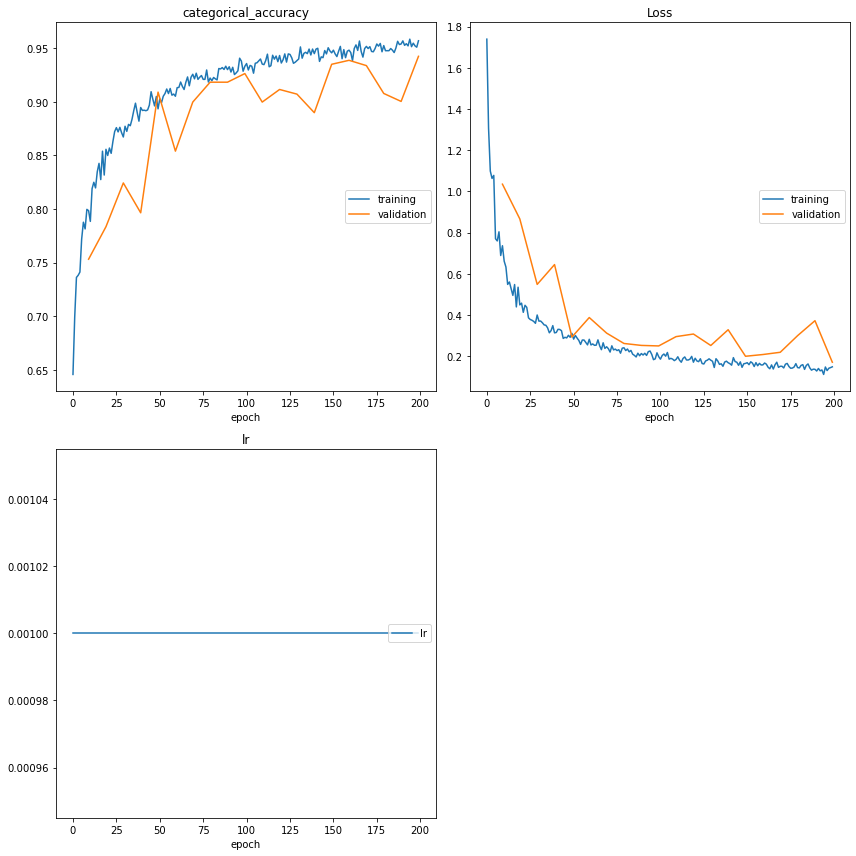

categorical_accuracy
	training         	 (min:    0.646, max:    0.959, cur:    0.957)
	validation       	 (min:    0.753, max:    0.942, cur:    0.942)
Loss
	training         	 (min:    0.112, max:    1.739, cur:    0.149)
	validation       	 (min:    0.171, max:    1.035, cur:    0.171)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
10/10 [==============================] - 1s 59ms/step - loss: 0.0609 - categorical_accuracy: 0.9875
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4190ms
Confusion Matrix
[[331   2   0   0   2   0   0   0   0   0   0   0]
 [  1  54   4   1   0   0   2   2   0   0   0   0]
 [  1   6 135   0   0   0   1   1   0   0   1   0]
 [  1   0   0  10   0   0   0   0   0   0   0   0]
 [  0   0   2   2 539   0   0   0   0   0   1   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   4   0   0   0   0  72   1   0   0   0   0]
 [  0   0   1   0   0   0   2  83   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1617 images belonging to 12 classes.
10/10 [==============================] - 1s 56ms/step - loss: 0.0609 - categorical_accuracy: 0.9875
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.3993ms
Confusion Matrix
[[331   2   0   0   2   0   0   0   0   0   0   0]
 [  1  54   4   1   0   0   2   2   0   0   0   0]
 [  1   6 135   0   0   0   1   1   0   0   1   0]
 [  1   0   0  10   0   0   0   0   0   0   0   0]
 [  0   0   2   2 539   0   0   0   0   0   1   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   4   0   0   0   0  72   1   0   0   0   0]
 [  0   0   1   0   0   0   2  83   0   0   0   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0]
 [ 10   1   0   0   0   0   0   0   0   0 223   0]
 [ 19   0   1   0   0   0   0   0   0   0  23  75]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.91      0.99      0.95 

In [3]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)
pipeline.params.number_of_classes = 12
pipeline.params.class_to_color_mapping = [
        'Purple',  # adenocarcinoma
        'Red',  # blood_and_vessels
        'silver',  # connective_tissue
        'White',  # empty
        'thistle',  # fat
        'magenta',  # inflammation_purulent
        'steelblue',  # muscle_cross_section
        'dodgerblue',  # muscle_longitudinal_section
        'darkred',  # necrosis
        'gold',  # nerve
        'seagreen',  # normal_mucosa
        'White'  # unknown
    ]
pipeline.params.class_names=sorted(list(selected_classes_feit.union( {'unknown'} )))

In [5]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2153.063221216202 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-augmented/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 4865.7418920993805 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-augmented/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 4718.730531692505 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-reduced-rgb-no-inception-augmented/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
------------------------------

In [5]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         128, pipeline.params.class_names,
                                         save_segmentations=False, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=False)

Processing region 120 out of 120
Post-processing image...
Processing grid point 41664 out of 41664
Processing image took 158.8165888786316 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 99960 out of 99960
Processing image took 369.54690885543823 seconds
Processing region 255 out of 255
Post-processing image...
Processing grid point 96577 out of 96577
Processing image took 348.06219577789307 seconds
Processing region 567 out of 567
Post-processing image...
Processing grid point 220296 out of 220296
Processing image took 751.7417695522308 seconds
Aggregated evaluation: 
[[26706   439   847   129    20     0     1    88     1     0  4811     0]
 [   69  3371   305    42   629     0   124    70     0     0   196     0]
 [  117   601  1091    74    57     2   121   714     3     0   488     0]
 [    0     8     0    61     1     0     0     0     0     0   730     0]
 [   23   882   281  2222 12335     0   103    38     2     0    45     0]
 [    4  